# Test estimating parameters from a Gaussian Process with a mean function

Start with the quantity of interest $\mathbf{y}$ is given by some process plus noise i.e.

$$
\mathbf{y_d} = \mathbf{f_d} + \epsilon, \ \ \ \ \ \epsilon\sim\mathcal{N}(0,\sigma^2)
$$

where 
$$
\mathbf{f_d}\sim \mathcal{N}(\mathbf{\mu_d}, K_{dd})
$$

and $\mathbf{f_d}$ is the Gaussian (normal) distribution of a function at data points, $\mathbf{\mu_d}$ is the mean values at the data points, $\Sigma_d$ is the covariance value at the data points (subscript "d" indicates a data point).

The goal of Gaussian process regression is to make predictions of the probability distribution at some new "model" points, subscript "m". After some maths

$$
p(\mathbf{y_m}|\mathbf{y_d})=\mathcal{N}(\mathbf{m_m},\mathbf{V_m})
$$

Another goal is to estimate the parameters in the vector $\theta=\lbrace\beta, \phi, \sigma\rbrace$ that describe the mean function, $\mathbf{\mu_d}(\mathbf{X};\beta)$ and the covariance function, $\mathbf{K_{dd}}(\mathbf{X};\phi)$. In practice, this is achieved by maximising the log-marginal likelihood function

$$
\log p(\mathbf{y}_d|\theta) = -\frac{1}{2}\left[ \mathbf{y}_d^T(\mathbf{K}_{dd}+\sigma^2\mathbf{I})^{-1}\mathbf{y}_d + \log|\mathbf{K}_{dd}+\sigma^2\mathbf{I}| +N\log 2\pi\right]
$$


In [1]:


from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from oceanoi.oijax import OptimalInterpJax as OptimalInterp
# usejax=True

# from oceanoi.oidask import OptimalInterpDask as OptimalInterp
from oceanoi.oiscipy import OptimalInterpScipy as OptimalInterp
usejax=False
# from oceanoi.oisparse import OptimalInterpSparse as OptimalInterp


In [3]:
# Define a linear mean function
def linear(x, meanparams, **kwargs):
    a,b = meanparams
    return a + b*x

def zero(x, meanparams, **kwargs):
    return 0*x

# Define an exponential quadratic covariance function
def expquad(x, xpr, covparams):
    eta, l = covparams
    return eta**2 * np.exp(-(x-xpr)*(x-xpr)/(2*l*l))

In [4]:
import jax.numpy as jnp

def expquadjax(x, xpr, covparams):
    eta, l = covparams
    return eta**2 * jnp.exp(-(x-xpr)*(x-xpr)/(2*l*l))

Now we want to generate some data $\mathbf{y_d} $ by pulling from a multivariate normal and adding some noise

$$
\mathbf{y_d} = \mathbf{f_d} + \epsilon, \ \ \ \ \ \epsilon\sim\mathcal{N}(0,\sigma^2) i.e.
$$

where 
$$
\mathbf{f_d}\sim \mathcal{N}(\mathbf{\mu_d}, K_{dd})
$$

Text(0.5, 0, 'x')

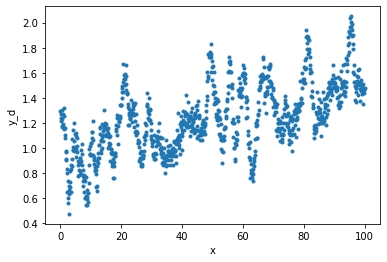

In [5]:
#####
# Define the parameters for the mean and covariance function (we hope to estimate these later...)
meanparams = (1, 0.005)
covparams = (0.2, 1.)
meanfunc = linear
covfunc = expquad
noise = 0.07

L = 100. # Length of the domain
N = 1000 # Number of data points

#####

x = np.linspace(0, L, N)[:,None] # N x 1 matrix (not N x 0 which is numpy's default)

mu = meanfunc(x, meanparams) # N x 1
K = covfunc(x, x.T, covparams) # N x N
y_d = np.random.multivariate_normal(mu.ravel(), K , 1).T
# Add the noise
y_d += np.random.normal(0, noise, (N,1))

plt.figure()
plt.plot(x, y_d ,'.')
plt.ylabel('y_d')
plt.xlabel('x')

Another way to draw from a multivariate norm is to multiply the cholesky by an order unity vector

$$
y_d = \mathbf{L} r, \ \ \ \ \ \ \ r\sim\mathcal{N}(0,1)
$$

where the lower triangular matrix L is the Cholesky decomposition of K_dd,

$$
K_{dd}=LL^T.
$$

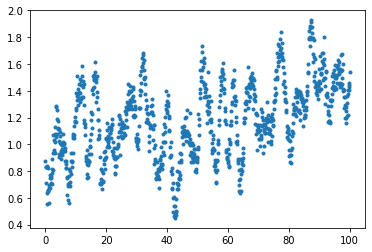

In [6]:
# Note we need to some noise on the diagonal of K for this to work
Lchol = linalg.cholesky(K+(1e-7+noise**2)*np.eye(N), lower=True)

r = np.random.normal(0,1, (N,1))

y_d_chol = Lchol.dot(r) + mu

plt.plot(x, y_d_chol,'.')

Now we use the OptimalInterp class to generate some data by sampling priors

In [7]:
if usejax:
    covfunc = expquadjax

<class 'numpy.ndarray'>


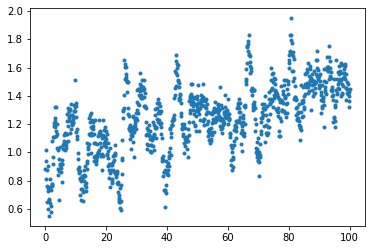

In [8]:
# Output (model) data points
xm = np.linspace(0, L+10, N+100)[:,None]

OI = OptimalInterp(x, xm, noise, covfunc, covparams,
                      mean_func=meanfunc, mean_params=meanparams,
                      chunksize=100)

# This will return a dask array
y_d_prior = OI.sample_prior(1)
print(type(y_d_prior))

plt.figure()
plt.plot(x, y_d_prior,'.')

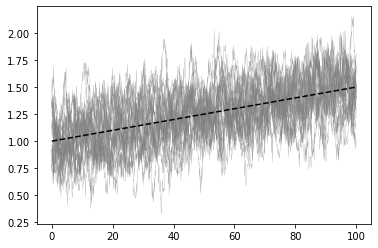

In [9]:
# We can also draw many priors and plot them over the mean function

y_d_prior = OI.sample_prior(20)

for ii in range(20):
    plt.plot(x, y_d_prior[:,ii],'0.5', lw=0.2)
plt.plot(x, mu,'k--')

Now, let's make predictions at the new points

Text(0.5, 0, 'x')

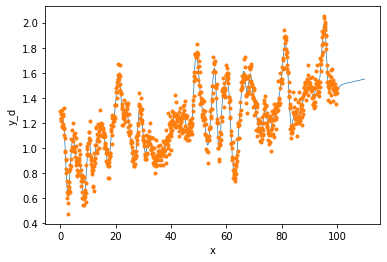

In [10]:
y_m_mu = OI(y_d)

plt.figure()
plt.plot(xm, y_m_mu , lw=0.7)
plt.plot(x, y_d ,'.')

plt.ylabel('y_d')
plt.xlabel('x')

The above just shows the mean function. We can show the full distribution of $\mathbf{y}_m$ by sampling from the posterior

(90.0, 110.0)

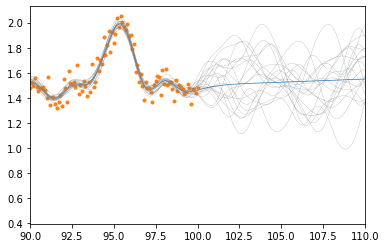

In [12]:
y_m_full = OI.sample_posterior(y_d, 20)

plt.figure()
plt.plot(xm, y_m_mu , lw=0.7)
plt.plot(x, y_d ,'.')

for ii in range(20):
    plt.plot(xm, y_m_full[:,ii],'0.5', lw=0.2)

plt.xlim(90,110)

In [13]:
lml = OI.log_marg_likelihood(y_d)
lml

(1, 1) 948.6935426358631 948.6935426358631


1071.956388731655

In [13]:
from oceanoi import driveroi

In [14]:
%%time
meanparams_ic = (0., 0.0)
covparams_ic = (0.1, 0.5)
noise_ic = 0.1

soln=driveroi.optimise_oi(
    x, y_d, 
    covfunc, covparams_ic,
    meanfunc, meanparams_ic,
    noise_ic,
    OIclass=OptimalInterp,
    verbose=False,
    method='L-BFGS-B',
)

print('Noise (real, estimated) = ({}, {})'.format(noise, soln['x'][0]))
print('Covparams (real, estimated) = ', covparams, soln['x'][1:3])
print('meanparams (real, estimated) = ', meanparams, soln['x'][3:])

Noise (real, estimated) = (0.07, 0.317585415860357)
Covparams (real, estimated) =  (0.2, 1.0) [0.25839248 0.7719296 ]
meanparams (real, estimated) =  (1, 0.005) [0.97874877 0.00519013]
CPU times: user 30.4 s, sys: 41.5 s, total: 1min 11s
Wall time: 18.1 s
